<div style="text-align: center">
    <span style="font-size: 20px">Homework</span>
    <br>
    <span style="font-size: 20px">TF4063 Sains Data Rekayasa</span>
    <br><br>
    <span style="font-size: 16px">13318006 Saleh Zaidan</span>
    <br>
    <span style="font-size: 16px">13318011 Yolanda Tania Mulyadi</span>
</div>
<hr>

Berikut adalah program untuk menyelesaikan *binary classification problem* dengan prior dan likelihood non-konjugat. Dalam penyelesaian model ini, marginal likelihood tidak dapat diabaikan dalam komputasi densitas *posterior*. Berdasarkan aturan Bayes, marginal likelihood didapat dari:

$$
p(\mathbf{t}|\mathbf{X}) = \int p(\mathbf{t}|\mathbf{X},\mathbf{w})p(\mathbf{w})\, d\mathbf{w}
$$

Namun kalkulasi persoalan ini sangat sulit dilakukan secara analitik. Oleh karena itu, akan digunakan pendekatan 3 macam metode untuk mendekati posterior.

1. Metode pertama adalah pendekatan MAP (*maximum a posteriori*). Dalam pendekatan ini, dicari titik tertinggi (puncak) posterior dengan mengasumsikan nilai $\mathbf{w}$ awal yang akan di-*update* dengan prosedure Newton-Raphson melalui iterasi.
2. Metode kedua adalah aproksimasi Laplace. Pendekatan ini mengaproksimasi posterior dengan distribusi lain, misalnya Gaussian.
3. Metode ketiga adalah algoritma **Metropolis-Hastings**. Metode ini akan menghasilkan beberapa sampel dari posterior yang akan digunakan untuk menghitung ekspektasi.

# Model Binary Responses

Tiap objek dideskripsikan oleh dua *attribute* $x_1$ dan $x_2$ yang memiliki respon biner $t = \{0, 1\}$. Jika $t = 0$ data akan diplot sebagai lingkaran sedangkan jika $t = 1$ maka diplot sebagai persegi. Definisikan:

$$
\mathbf{x}_n =
\begin{bmatrix}
x_{n1} \\
x_{n2}
\end{bmatrix}
, \; \mathbf{w} =
\begin{bmatrix}
w_1 \\
w_2
\end{bmatrix}
, \; \mathbf{X} =
\begin{bmatrix}
\mathbf{x}^\mathrm{T}_1 \\
\mathbf{x}^\mathrm{T}_2 \\
\vdots \\
\mathbf{x}^\mathrm{T}_N \\
\end{bmatrix}
$$

Akan digunakan prior dengan densitas $\mathcal{N}(\mathbf{0}, \sigma^2\mathbf{I})$ yang akan dihasilkan oleh `scipy.stats.multivariate_normal` dengan *seed* tetap.

Sigmoid function dapat didefinisikan sebagai:

$$
P(T_n=1|\mathbf{x}_n, \mathbf{w}) =\frac{1}{1+\exp(-\mathbf{w}^\mathrm{T}\mathbf{x}_n)}
$$

Likelihood untuk setiap $N$ data *training* model:

$$
p(\mathbf{t}|\mathbf{X}, \mathbf{w}) = P(T_n=1|\mathbf{x}_n, \mathbf{w})^{t_n}(1-P(T_n=1|\mathbf{x}_n,\mathbf{w}))^{1-t_n}
$$

sehingga dapat ditulis sebagai:

$$
p(\mathbf{t}|\mathbf{X}, \mathbf{w}) = \prod_{n=1}^{N}\left(\frac{1}{1+\exp(-\mathbf{w}^\mathrm{T}\mathbf{x}_{n})}\right)^{t_n} \left(\frac{\exp(-\mathbf{w}^\mathrm{T}\mathbf{x}_{n})}{1+\exp(-\mathbf{w}^\mathrm{T}\mathbf{x}_{n})}\right)^{1-t_n}
$$

Nilai ekspektasi dari aproksimasi posterior dapat diperoleh dari:

$$
P(T_\mathrm{new} = 1|\mathbf{x}_\mathrm{new}, \mathbf{X}, \mathbf{t}, \sigma^2) = \frac{1}{N_s} \sum_{s=1}^{N_s} \frac{1}{1+\exp(-\mathbf{w}_s^\mathrm{T} \mathbf{x}_\mathrm{new})}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.io import loadmat
from scipy.stats import multivariate_normal, uniform
from matplotlib import rcParams
from IPython.display import set_matplotlib_formats

%matplotlib inline
rcParams["mathtext.fontset"] = "cm"
set_matplotlib_formats("svg")

Variabel-variabel umum yang digunakan pada program adalah:

`x` : `numpy.ndarray (N, M)` Attribute data

`t` : `numpy.ndarray (N, 1)` Respon data

`N` : `int` Jumlah data

`M` : `int` Jumlah *attribute*

`covar` : `int` *Covariance* dari prior

In [2]:
# Shorter notation
mvn = multivariate_normal

# Load dataset
mat_data = loadmat("logregdata.mat")

# attributes, x1 and x2
x = mat_data["X"]
# binary response
t = mat_data["t"]

# N : number of data
# M : number of attributes
N, M = x.shape
lim = np.floor(x.min()), np.ceil(x.max())

# Create grid
xy = np.linspace(lim[0], lim[1], N)
xx, yy = np.meshgrid(xy, xy)

# Random generator fixed seed
seed = 1

# Prior gaussian covariance
covar = 10

Untuk mengelompokkan berbagai fungsi yang digunakan maka dibentuk 3 buah `class`, yaitu:
1. `Misc`: Pengklasifikasian data dan pembuatan plot
2. `Utility`: Melakukan perhitungan kecil, pengambilan sampel parameter, dan eksekusi algoritma
3. `Plot`: Menghasilkan plot dari 3 macam metode aproksimasi posterior

In [3]:
class Misc:
    def classify(self, x, t):
        """
        Mengklasifisikan data x berdasarkan respon biner t.
        """
        x0 = np.zeros(x.shape)
        x1 = np.zeros(x.shape)
        for i in range(N):
            if t[i] == 0:
                x0[i] = x[i]
            else:  # t[i] == 1
                x1[i] = x[i]

        return x0, x1

    def plot_data(self, x, t):
        """
        Plot data x berdasarkan respon. Untuk respon 0 akan diplot sebagai 
        lingkaran, sedangkan respon 1 sebagai persegi.
        """
        X = self.classify(x, t)
        plt.scatter(X[0][:, 0], X[0][:, 1], marker="o", color="k")
        plt.scatter(X[1][:, 0], X[1][:, 1], marker="s", color="w", \
                    edgecolors="k")
        plt.xlabel(r"$x_1$", fontsize=14)
        plt.ylabel(r"$x_2$", fontsize=14)
        plt.xlim(lim)
        plt.ylim(lim)

    def plot_contour(self, x, P, title):
        """
        Plot contour hasil perhitungan ekspektasi terhadap posterior untuk
        nilai ekspektasi posterior P.
        """
        levels = np.arange(0.1, 1.0, 0.1)
        cs = plt.contour(xx, yy, P, levels=levels, colors="k", linewidths=1)
        plt.clabel(cs, [0.1, 0.5, 0.9], fmt="%.1f")
        plt.title(title)
        plt.show()

In [4]:
class Utility:
    def P_func(self, x, w):
        return 1.0/(1.0 + np.exp(-x @ w))

    def hessian_func(self, w, x, covar):
        P = self.P_func(x, w).flatten()
        return (-1.0/covar) * np.eye(w.shape[0]) - x.T @ \
        np.diag(P*(1.0-P)) @ x

    def partial_func(self, w, x, t, covar):
        P = self.P_func(x, w)
        return (-1.0/covar) * w + x.T @ (t - P)

    def likelihood_func(self, x, w, t):
        P = 1.0
        for i in range(N):
            p = 1.0/(1.0 + np.exp(-(w[0]*x[i,0] + w[1]*x[i,1])))
            P = P * p**(t[i])*(1-p)**(1- t[i])
        
        return P
    
    def MAP(self, x, t, covar, error_max=0.5, i_max=100):
        """
        Menghasilkan satu nilai parameter berdasarkan estimasi maximum a 
        posteriori (MAP).
        
        Parameter:
        x : numpy.ndarray (N, M)
            Attribute data
        t : numpy.ndarray (N, 1)
            Respon data
        covar : int
            Nilai covariance prior (multivariate normal)
        error_max : int, opsional
            Nilai error iterasi maksimum. Default adalah 0.5
        i_max : int, opsional
            Jumlah iterasi maksimum. Default adalah 100
            
        Return:
        numpy.ndarray (M, 1)
            Nilai parameter estimasi MAP
        """
        w = np.zeros((M, 1))
        error = 1.0
        i = 0

        while (error > error_max and i <= i_max):
            w_old = w.copy()
            hessian = self.hessian_func(w, x, covar)
            partial = self.partial_func(w, x, t, covar)
            w = w - inv(hessian) @ partial
            i += 1
            error = np.average(((w - w_old) / w) * 100)
        
        return w

    def laplace(self, x, t, covar, Ns=10000):
        """
        Menghasilkan sekumpulan nilai parameter berdasarkan sampling dengan 
        aproksimasi Laplace.
        
        Parameter:
        x : numpy.ndarray (N, M)
            Attribute data
        t : numpy.ndarray (N, 1)
            Respon data
        covar : int
            Nilai covariance prior (multivariate normal)
        Ns : int, opsional
            Jumlah sampel. Default adalah 10000
            
        Return:
        numpy.ndarray (Ns, M)
            Sekumpulan parameter hasil aproksimasi Laplace
        """
        mu = self.MAP(x, t, covar)
        v = self.hessian_func(mu, x, covar)
        sigma = inv(-v)

        w_samps = mvn.rvs(mu.flatten(), sigma, Ns, random_state=seed)

        return w_samps

    def MH(self, x, t, covar, Ns=10000):
        """
        Menghasilkan sekumpulan nilai parameter berdasarkan sampling dengan 
        algoritma Metropolis-Hastings.
        
        Parameter:
        x : numpy.ndarray (N, M)
            Attribute data
        t : numpy.ndarray (N, 1)
            Respon data
        covar : int
            Nilai covariance prior (multivariate normal)
        Ns : int, opsional
            Jumlah sampel. Default adalah 10000
            
        Return:
        numpy.ndarray (Ns, M)
            Sekumpulan parameter hasil algoritma Metropolis-Hastings
        """
        # Initial sample
        w = np.zeros((M, 1))
        sigma = np.eye(M)/10

        # Prior density parameter (gaussian)
        mean = np.zeros((M, 1))
        covar = np.eye(M) * covar

        w_samps = [w.flatten()]

        for i in range(Ns):
            # Propose new candidate
            ws = mvn.rvs(w.flatten(), sigma).T
            r = mvn.pdf(ws.flatten(), mean.flatten(), covar) \
                / mvn.pdf(w.flatten(), mean.flatten(), covar) \
                * self.likelihood_func(x, ws, t) \
                / self.likelihood_func(x, w, t)
            if r > 1: # accept
                w_samps.append(ws.flatten())
                w = ws
            else:
                u = uniform.rvs()
                if u <= r: # accept
                    w_samps.append(ws.flatten())
                    w = ws
                else: # reject
                    w_samps.append(w.flatten())
        w_samps = np.array(w_samps)

        return w_samps

In [5]:
class Plot:
    def MAP(self, x, t, covar):
        w = utility.MAP(x, t, covar)
        P = 1.0/(1.0 + np.exp(-(w[0]*xx + w[1]*yy)))

        title = "Plot contour dari $P\,(T_n=1)$ dengan estimasi MAP"
        misc.plot_data(x, t)
        misc.plot_contour(x, P, title)

    def laplace(self, x, t, covar, Ns=10000):
        w = utility.laplace(x, t, covar, Ns)

        P = np.zeros(N)
        for i in range(Ns):
            P = P + 1.0/(1.0 + np.exp(-(w[i, 0]*xx + w[i, 1]*yy)))
        P = P / Ns

        title = "Plot contour dari $P\,(T_n=1)$ dengan aproksimasi " \
        "Laplace $(N_s=%d)$" % Ns
        misc.plot_data(x, t)
        misc.plot_contour(x, P, title)

    def MH(self, x, t, covar, Ns=10000):
        w = utility.MH(x, t, covar, Ns)

        P = np.zeros(N)
        for i in range(Ns):
            P = P + 1.0/(1.0 + np.exp(-(w[i, 0]*xx + w[i, 1]*yy)))
        P = P / Ns

        title = "Plot contour dari $P\,(T_n=1)$ dengan algoritma " \
        "Metropolis-Hastings $(N_s=%d)$" % Ns
        misc.plot_data(x, t)
        misc.plot_contour(x, P, title)

In [6]:
# Initialize object for each class
misc = Misc()
utility = Utility()
plot = Plot()

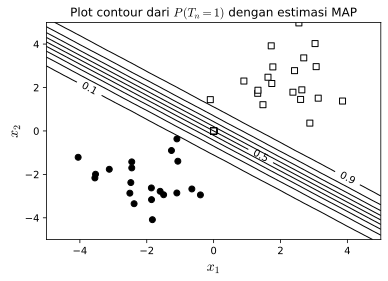

In [7]:
plot.MAP(x, t, covar)

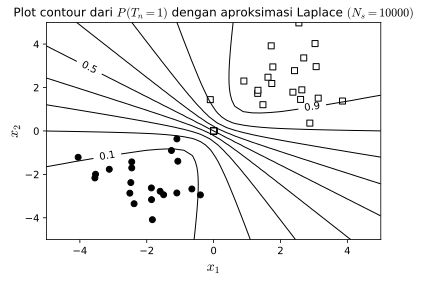

In [8]:
plot.laplace(x, t, covar)

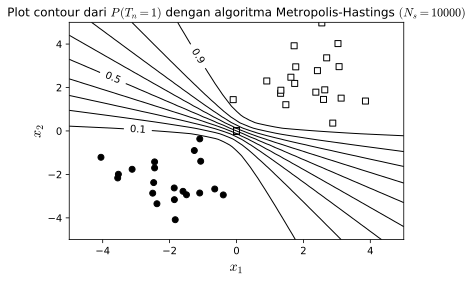

In [9]:
plot.MH(x, t, covar)